# Data Mining
## Knowledge Extraction through Data Analysis

### This notebook presents some tests on Data Analysis, including Locality Sensitive Hashing (LSH).
#### The topic of this experimentation is duplicate questions detection.

In this experiment we want to determine how many of the questions in the test set exist in the training set.

<u>Note</u>: The dataset is not provided since I was given this dataset as part of an assignment and I do not know whether I am allowed to share it.

#### This notebook uses Python version 3.6 or newer.

Let's start by installing the necessary libraries and toolkits using both Conda and Pip.

In [1]:
import sys

if int(sys.version[0]) < 3 or int(sys.version[2]) < 6:
    assert("Python version 3.6 or newer is required")

We continue by importing the necessary libraries and toolkits.

In [2]:
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
from datasketch import MinHash, MinHashLSH
from datetime import date, datetime
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from scipy.sparse import csr_matrix, vstack
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


%matplotlib inline

## Data Exploration

Let's load the training dataset into a Pandas Dataframe and take perform some data exploration.

In [3]:
df_train = pd.read_csv('./datasets/q2a/corpusTrain.csv', sep=',', index_col=0, dtype=str)
df_train.head()

,Content
Id,
0,How many people are going towards using phones...
1,What audio format should I use for getting aud...
2,What is the corporate culture like at Edwards ...
3,What is the best barbecue in Kansas City?\n
4,"""Can I combine the output of two bolts to one ..."


Let's check the number records in this dataset.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531990 entries, 0 to 531989
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  531990 non-null  object
dtypes: object(1)
memory usage: 8.1+ MB


Now, let's check for NULL values.

In [5]:
pd.DataFrame({'null_count': df_train.isnull().sum(), 'null_percentage': round(df_train.isnull().sum() * 100 / df_train.shape[0],2)})

,null_count,null_percentage
Content,0,0.0


We can see that 0 out of 531990 records in the training set contain NULL values, which means all questions contain text.

Let's take a look at our questions, using a WordCloud.

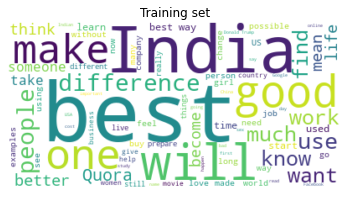

In [6]:
# Extract questions from DataFrame as a string.
text = ''.join(df_train['Content'].to_list())

# Create a Word Cloud
wordcloud = WordCloud(stopwords=set(STOPWORDS), max_words=80, background_color="white", normalize_plurals=False)
image = wordcloud.generate_from_text(text)

# Plot wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Training set")
plt.show()

Now, we will perform the same steps for the test set.

In [7]:
df_test = pd.read_csv('./datasets/q2a/corpusTest.csv', sep=',', index_col=0, dtype=str)
df_test.head()

,Content
Id,
0,How do I get good marks in college?\n
1,Can an android app use SMS only to communicate...
2,What small detail from an Indian movie do you ...
3,Why can not Hindu women be the soldier of Hind...
4,How would you write out twelve lakh twelve tho...


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5374 entries, 0 to 5373
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  5374 non-null   object
dtypes: object(1)
memory usage: 84.0+ KB


Now, let's check for NULL values.

In [9]:
pd.DataFrame({'null_count': df_test.isnull().sum(), 'null_percentage': round(df_test.isnull().sum() * 100 / df_test.shape[0],2)})

,null_count,null_percentage
Content,0,0.0


We can see that 0 out of 5374 records in the test set contain NULL values, which means all questions contain text.

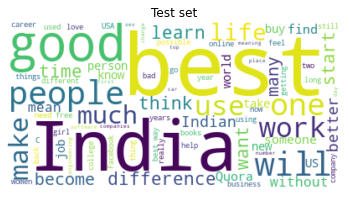

In [10]:
# Extract questions from DataFrame as a string.
text = ''.join(df_test['Content'].to_list())

# Create a Word Cloud
wordcloud = WordCloud(stopwords=set(STOPWORDS), max_words=80, background_color="white", normalize_plurals=False)
image = wordcloud.generate_from_text(text)

# Plot wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Test set")
plt.show()

From the word clouds we notice a grear similarity between words in questions in training set and test set.

## Data Preprocessing

Before we proceed with the comparisons, we should perform some <b>text preprocessing</b> on both datasets, to achieve better results.<br/>
This preprocessing includes:
* Removing URLs
* Removing English stop words
* Removing non-alphanumeric characters
* Stemming words
* Replacing empty strings, after preprocessing, with the "emptystring" string

In [11]:
def remove_hyperlinks(text):
    """ Removes hyperlinks """
    text = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-])', ' ', text)
    return text

def remove_html_tags(text):
    text = re.sub('<[^>]+>', ' ', text)
    return text

def expand_contractions(text, contractions_re, contractions_dict):
    """ Replaces contractions with the full words (e.g. I'll --> I will) """
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

def remove_non_letters(text):
    """ Removes non-english letter characters """
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return text

def text_preprocess(text, contractions_re, contractions_dict, stopwords=None, lemmatizer=None, stemmer=None):
    """ Preprocesses (cleans) text by performing the following operations:
    * Converts text to lowercase
    * Expands contractions
    * Removes URLs
    * Removes non-alphanumeric characters
    * Removes non-digit characters
    * Removes tabs and redundant whitespaces
    * Performs stemming
    * Performs lemmatization
    * Replaces empty strings and NULL entries (before and after preprocessing), with the string "emptystring"
    """
    if text and text is not np.nan and text.lower() != 'nan':
        text = text.lower()
        text = remove_hyperlinks(text)
        text = remove_html_tags(text)
        text = expand_contractions(text, contractions_re, contractions_dict)
        text = remove_non_letters(text)
        tokens = nltk.word_tokenize(text)
        if not tokens:
            text = 'emptystring'
        else:
            if stemmer:
                tokens = [stemmer.stem(token) for token in tokens]
            if lemmatizer:
                tokens = [lemmatizer.lemmatize(token) for token in tokens]
            tokens = [x for x in tokens if x not in set(stopwords)]
            text = ' '.join(tokens)
            if not text or len(text) < 3:
                text = 'emptystring'
        
    return text

# Download NLTK tools
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initializes stop words, stemmer and lemmatizer
stop_words = set(stopwords.words('english')+list(STOPWORDS)+list(ENGLISH_STOP_WORDS))
# stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

# Dictionary with contractions
contractions_dict = {"ain't": "are not", "'s":" is", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "‘cause": "because", 
                     "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", 
                     "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", 
                     "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "how'd": "how did", "how'd'y": "how do you", 
                     "how'll": "how will", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", 
                     "I've": "I have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", 
                     "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", 
                     "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", 
                     "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                     "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                     "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "that'd": "that would", 
                     "that'd've": "that would have", "there'd": "there would", "there'd've": "there would have", "they'd": "they would", 
                     "they'd've": "they would have","they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                     "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                     "we're": "we are", "we've": "we have", "weren't": "were not","what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                     "what've": "what have", "when've": "when have", "where'd": "where did", "where've": "where have", "who'll": "who will", 
                     "who'll've": "who will have", "who've": "who have", "why've": "why have", "will've": "will have", "won't": "will not", 
                     "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
                     "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", 
                     "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Regular expression to identify contractions
contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
df_train['processed_text'] = df_train['Content'].apply(text_preprocess, args=(contractions_re, contractions_dict, stop_words, lemmatizer))
df_test['processed_text'] = df_test['Content'].apply(text_preprocess, args=(contractions_re, contractions_dict, stop_words, lemmatizer))

Let's take a look at what we achieved with this preprocessing.

In [13]:
df_train.head()

,Content,processed_text
Id,,
0,How many people are going towards using phones...,people going using phone search local business
1,What audio format should I use for getting aud...,audio format use getting audio track live perf...
2,What is the corporate culture like at Edwards ...,corporate culture edward lifesciences culture ...
3,What is the best barbecue in Kansas City?\n,best barbecue kansa city
4,"""Can I combine the output of two bolts to one ...",combine output bolt bolt apache storm using sh...


In [14]:
df_test.head()

,Content,processed_text
Id,,
0,How do I get good marks in college?\n,good mark college
1,Can an android app use SMS only to communicate...,android app use sm communicate question intell...
2,What small detail from an Indian movie do you ...,small indian movie love
3,Why can not Hindu women be the soldier of Hind...,hindu woman soldier hinduism birth hindu kid m...
4,How would you write out twelve lakh twelve tho...,write lakh thousand numerically


## Data Preparation

We know that vectorized operations significantly increase the efficiency and the execution speed of arithmetic operations.<br/>
For this reason, we are going to perform as many vectorized operations as possible, to speed-up the execution.<br/>
Otherwise, we would have to wait days before we could get any result.

Now, we should convert the questions to <b>binary word vectors</b>, in order to be able to compare them efficiently with each other.

In [15]:
vectorizer = CountVectorizer(token_pattern=r'\w{3,}', ngram_range=(1, 3), min_df=2, binary=True)

vectorizer.fit(df_train['processed_text'])

train_vectors = vectorizer.transform(df_train['processed_text'])
test_vectors = vectorizer.transform(df_test['processed_text'])

## Comparisons

Now, we should define the parameters we are going to use across all experiments.

* Similarity threshold 80% - this means that two questions are considered duplicate if their similarity score is higher than 80%.
* Split factor 10% - this means we compare the test set against 10% of our training set in every epoch, leading to the need of 10 epochs to complete the comparisons.

In [16]:
sim_thresh=0.8
split_factor=0.1

### Cosine similarity - One VS All

In our first experiment, we are going to perform an One-VS-All comparison, using cosine similarity as the similarity metric.

In [17]:
# Cosine similarity - one VS all


# Search for duplicates
def query(train_vectors, test_vectors, sim_thresh=0, split_factor=1.0):
    """
    train_vectors: questions in training set (in vector form)
    test_vectors: questions in test set (in vector form)
    sim_thresh: similarity threshold above which questions are considered similar
    split_factor: split training vectors into chunks, to avoid memory overflow
    """
    
    n = int(math.floor(1.0/split_factor))
    m = int(math.floor(split_factor * train_vectors.shape[0]))
    
    duplicates = np.array([])
    
    print("Searching for duplicates using cosine similarity...")
    
    start_time = datetime.now()
    
    for i in range(n):
        arr = np.where(np.any(cosine_similarity(test_vectors, train_vectors[i*m:i*m+m]) > sim_thresh, axis=1))
        duplicates = np.union1d(duplicates, arr)
    arr = np.where(np.any(cosine_similarity(test_vectors, train_vectors[i*m:i*m+m]) > sim_thresh, axis=1))
    duplicates = np.union1d(duplicates, arr)
    
    end_time = datetime.now()
    
    duration = datetime.combine(date.min, end_time.time()) - datetime.combine(date.min, start_time.time())
    duration = duration.total_seconds()
    
    print("Search complete!")
    
    return duplicates.size, duration



print("-" * 40)

duplicate_pairs, query_time = query(train_vectors=train_vectors, test_vectors=test_vectors, sim_thresh=sim_thresh, split_factor=split_factor)

print(f"Time to complete comparisons: {query_time} seconds")
print(f"Total time: {query_time}")
print(f"Duplicates: {duplicate_pairs}")
print("-" * 40)

----------------------------------------
Searching for duplicates using cosine similarity...
Search complete!
Time to complete comparisons: 39.245369 seconds
Total time: 39.245369
Duplicates: 1752
----------------------------------------


### Jaccard similarity - One VS All

In our second experiment, we are going to perform an One-VS-All comparison, using Jaccard similarity as the similarity metric.

In [18]:
# Jaccard similarity - one VS all


def pairwise_jaccard_sparse(csr, idx, sim_thresh=0):
    """Computes the Jaccard distance between the rows of `csr`,
    returning rows from idx and afterwards whose similarity is
    higher than the cut-off distance `sim_thresh`.
    """
    assert(0 < sim_thresh < 1)
    
    csr_rownnz = csr.getnnz(axis=1)
    intrsct = csr.dot(csr.T)
    
    nnz_i = np.repeat(csr_rownnz, intrsct.getnnz(axis=1))
    unions = nnz_i + csr_rownnz[intrsct.indices] - intrsct.data
    sims = intrsct.data / unions.astype('float64')
    
    mask = (sims > sim_thresh) & (sims < 1.0)
    data = sims[mask]
    indices = intrsct.indices[mask]

    rownnz = np.add.reduceat(mask, intrsct.indptr[:-1])
    indptr = np.r_[0, np.cumsum(rownnz)]
    
    out = csr_matrix((data, indices, indptr), intrsct.shape)
    
    return out[idx:, :idx].nonzero()[0]


# Search for duplicates
def query(train_vectors, test_vectors, sim_thresh=0, split_factor=1.0):
    """
    train_vectors: questions in training set (in vector form)
    test_vectors: questions in test set (in vector form)
    sim_thresh: similarity threshold above which questions are considered similar
    split_factor: split training vectors into chunks, to avoid memory overflow
    """
    
    n = int(math.floor(1.0/split_factor))
    m = int(math.floor(split_factor * train_vectors.shape[0]))
    
    duplicates = np.array([])
    
    print("Searching for duplicates using Jaccard similarity...")
    
    start_time = datetime.now()
    
    for i in range(n):
        csr = vstack([train_vectors[i*m:i*m+m], test_vectors])
        arr = pairwise_jaccard_sparse(csr, m, sim_thresh)
        duplicates = np.union1d(duplicates, arr)
    csr = vstack([train_vectors[i*m:], test_vectors])
    arr = pairwise_jaccard_sparse(csr, m, sim_thresh)
    duplicates = np.union1d(duplicates, arr)
    
    end_time = datetime.now()
        
    duration = datetime.combine(date.min, end_time.time()) - datetime.combine(date.min, start_time.time())
    duration = duration.total_seconds()
    
    print("Search complete!")
    
    return duplicates.size, duration



print("-" * 40)

duplicate_pairs, query_time = query(train_vectors=train_vectors, test_vectors=test_vectors, sim_thresh=sim_thresh, split_factor=split_factor)

print(f"Time to complete comparisons: {query_time} seconds")
print(f"Total time: {query_time}")
print(f"Duplicates: {duplicate_pairs}")
print("-" * 40)

----------------------------------------
Searching for duplicates using Jaccard similarity...
Search complete!
Time to complete comparisons: 59.687798 seconds
Total time: 59.687798
Duplicates: 349
----------------------------------------


Clearly, the number of duplicates using cosine similarity is significantly higher than the number of duplicates using Jaccard similarity.

### Cosine similarity - LSH

Another way of performing the comparisons is utilizing Locality-Sensitive Hashing (LSH).

In the following experiment, we are going to use LSH through SimHash for cosine similarity with random binary projection.

In [19]:
# Cosine similarity through LSH indexing
# Custom personal implementation utilizing MinHash and Random Binary Projection


class LSH_cosine:
    def __init__(self, hash_size, dimensions):
        self.k = hash_size
        self.dim = dimensions
        self.ref_planes = csr_matrix(np.random.randn(self.k, self.dim))
        self.hash_table = dict()
    
    def index(self, data):
        """
        LSH signature generation using random projection
        Returns the signature bits for a number of data points.
        The signature bits of the points are different
        only for the plane that divides the two points.
        """
        keys = self.__hash(data)
        
        for i in range(data.shape[0]):
            self.hash_table.setdefault(keys[i].tobytes(), []).append(data[i])
    
    def query(self, data, threshold=0):
        keys = self.__hash(data)
        
        neighbors = []
        
        for i in range(data.shape[0]):
            candidates = []
            candidates.extend(self.hash_table.get(keys[i].tobytes()))
            candidates_matrix = vstack(candidates)
            similarities = cosine_similarity(candidates_matrix, data[i]) > threshold
            neighbors.append(candidates_matrix[similarities[:,0]])
        
        return neighbors
    
    def __hash(self, data):
        projs = data @ self.ref_planes.T
        signs = (projs > 0)
        keys = np.packbits(signs.toarray(), axis=-1)
        
        return keys

# Build LSH index using MinHash
def build_index(vectors, k=64, train_percentage=1.0):
    
    dim = train_vectors.shape[1]
    
    # Create LSH index
    lsh_index = LSH_cosine(hash_size=k, dimensions=dim)
    
    print("Indexing vectors using k=" + str(k) + "...")
    
    start_time = datetime.now()
    
    # Index train vectors
    lsh_index.index(vectors)
    
    end_time = datetime.now()
    
    duration = datetime.combine(date.min, end_time.time()) - datetime.combine(date.min, start_time.time())
    duration = duration.total_seconds()
    
    print("Index built!")
    print("Time to build the index: " + str(duration) + " seconds")
    
    return lsh_index, duration


# Search for duplicates
def query(vectors, lsh_index, k, sim_thresh=0):
    
    duplicates = 0
    
    print("Searching for duplicates using k=" + str(k) + "...")
    
    start_time = datetime.now()
    
    results = lsh_index.query(test_vectors, threshold=sim_thresh)
    
    for result in results:
        if result.size:
            duplicates += 1
    
    end_time = datetime.now()
            
    duration = datetime.combine(date.min, end_time.time()) - datetime.combine(date.min, start_time.time())
    duration = duration.total_seconds()
    
    print("Search complete!")
    print("Time to complete the search: " + str(duration) + " seconds")
    
    return duplicates, duration



duplicates = []
index_times = []
query_times = []
k_list = list(range(2,12))

print("Searching for duplicates using LSH, cosine distance and random binary projection")

print("-" * 40)

for k in k_list:

    print("Using k=" + str(k))

    lsh_index, index_time = build_index(vectors=train_vectors, k=k)
    duplicate_pairs, query_time = query(vectors=test_vectors, lsh_index=lsh_index, k=k, sim_thresh=sim_thresh)
    
    index_times.append(index_time)
    query_times.append(query_time)
    duplicates.append(duplicate_pairs)

    print("Total time: " + str(index_time + query_time))
    print("Duplicates: " + str(duplicate_pairs))
    print("-" * 40)

Searching for duplicates using LSH, cosine distance and random binary projection
----------------------------------------
Using k=2
Indexing vectors using k=2...
Index built!
Time to build the index: 63.564225 seconds
Searching for duplicates using k=2...
Search complete!
Time to complete the search: 11309.529705 seconds
Total time: 11373.093930000001
Duplicates: 1499
----------------------------------------
Using k=3
Indexing vectors using k=3...
Index built!
Time to build the index: 60.834016 seconds
Searching for duplicates using k=3...
Search complete!
Time to complete the search: 6179.914195 seconds
Total time: 6240.748211
Duplicates: 1444
----------------------------------------
Using k=4
Indexing vectors using k=4...
Index built!
Time to build the index: 61.184582 seconds
Searching for duplicates using k=4...
Search complete!
Time to complete the search: 3279.564179 seconds
Total time: 3340.748761
Duplicates: 1373
----------------------------------------
Using k=5
Indexing vecto

Let's plot the results.

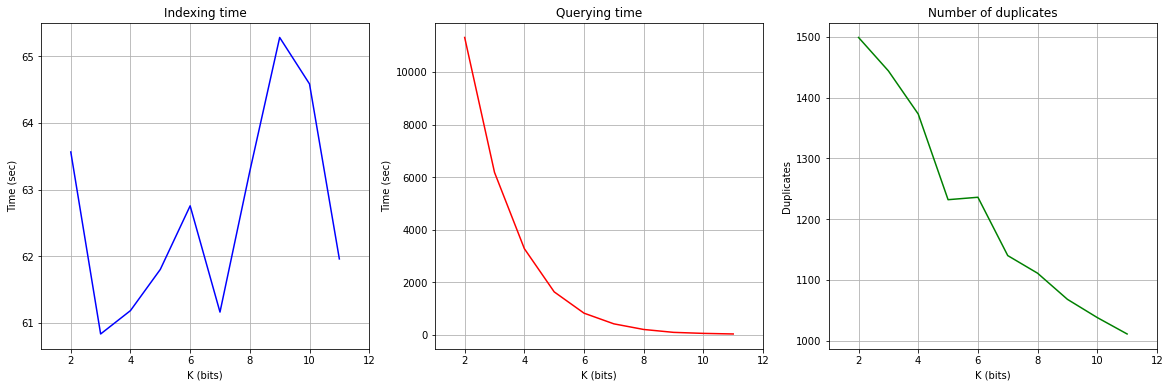

In [20]:
fig = plt.figure(figsize=(20, 6))

plt.subplot(1,3,1)
plt.plot(k_list, index_times, color='b')
plt.xlim(1,k_list[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Time (sec)')
plt.title("Indexing time")

plt.subplot(1,3,2)
plt.plot(k_list, query_times, color='r')
plt.xlim(1,k_list[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Time (sec)')
plt.title("Querying time")

plt.subplot(1,3,3)
plt.plot(k_list, duplicates, color='g')
plt.xlim(1,k_list[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Duplicates')
plt.title("Number of duplicates")

plt.show()

We can see that while the indexing time ranges between 58 and 62 seconds for every value of K, the querying time drops significantly as the value of K increases.

Furthermore, the number of duplicates drops almost linearly as the value of K increases, as was expected, since more projection bits give a better representation of the projected vector.

Finally, compared to the One-VS-All approach, we notice that the number of duplicates is lower when we use LSH when $\text{K}\geq 2$, and the reason this happens is because of the false negatives that are unavoidable when using LSH.

### Jaccard similarity - LSH

In the following experiment, we are going to use LSH through MinHash for Jaccard similarity.

In [21]:
# Jaccard similarity through LSH indexing
# Implementation based on https://github.com/ekzhu/datasketch



# Hash a vector using MinHash
def hash_vector(vector, num_perm):
    
    minhash = MinHash(num_perm=num_perm)
    
    for coef in vector.todense():
        minhash.update(coef)
    
    return minhash

# Build LSH index using MinHash
def build_index(vectors, num_perm, sim_thresh=0.8, train_percentage=1.0):
    
    lsh_index = MinHashLSH(sim_thresh, num_perm=num_perm)
    
    print("Building index using " + str(num_perm) + " permutation functions...")
    
    start_time = datetime.now()
    
    for index, vector in enumerate(vectors[:int(vectors.shape[0] * train_percentage)]):
        hashed_vector = hash_vector(vector, num_perm)
        lsh_index.insert(index, hashed_vector)
    
    end_time = datetime.now()
    
    duration = datetime.combine(date.min, end_time.time()) - datetime.combine(date.min, start_time.time())
    duration = duration.total_seconds()
    
    print("Index built!")
    print("Time to build the index: " + str(duration) + " seconds")
    
    return lsh_index, duration

# Search for duplicates
def query(vectors, lsh_index, num_perm):
    
    duplicates = 0
    
    print("Searching for duplicates using " + str(num_perm) + " permutation functions...")
    
    start_time = datetime.now()
    
    for vector in vectors:
        hashed_vector = hash_vector(vector, num_perm)
        result = lsh_index.query(hashed_vector)
        
        if result:
            duplicates += 1
    
    end_time = datetime.now()
            
    duration = datetime.combine(date.min, end_time.time()) - datetime.combine(date.min, start_time.time())
    duration = duration.total_seconds()
    
    print("Search complete!")
    print("Time to complete the search: " + str(duration) + " seconds")
    
    return duplicates, duration



duplicates = []
index_times = []
query_times = []
perm_list = [16 * 2**i for i in range(6)]

print("Searching for duplicates using LSH and Jaccard distance")

print("-" * 40)

for perm in perm_list:

    print(f"Using {perm} permutation functions")
    
    lsh_index, index_time = build_index(vectors=train_vectors, num_perm=perm)
    duplicate_pairs, query_time = query(vectors=test_vectors, lsh_index=lsh_index, num_perm=perm)
    
    index_times.append(index_time)
    query_times.append(query_time)
    duplicates.append(duplicate_pairs)

    print("Total time: " + str(index_time + query_time))
    print("Duplicates: " + str(duplicate_pairs))
    print("-" * 40)

Searching for duplicates using LSH and Jaccard distance
----------------------------------------
Using 16 permutation functions
Building index using 16 permutation functions...
Index built!
Time to build the index: 3012.883576 seconds
Searching for duplicates using 16 permutation functions...
Search complete!
Time to complete the search: 30.025734 seconds
Total time: 3042.90931
Duplicates: 811
----------------------------------------
Using 32 permutation functions
Building index using 32 permutation functions...
Index built!
Time to build the index: 3044.977837 seconds
Searching for duplicates using 32 permutation functions...
Search complete!
Time to complete the search: 30.651313 seconds
Total time: 3075.6291499999998
Duplicates: 811
----------------------------------------
Using 64 permutation functions
Building index using 64 permutation functions...
Index built!
Time to build the index: 3322.948995 seconds
Searching for duplicates using 64 permutation functions...
Search complete!

Let's plot the results.

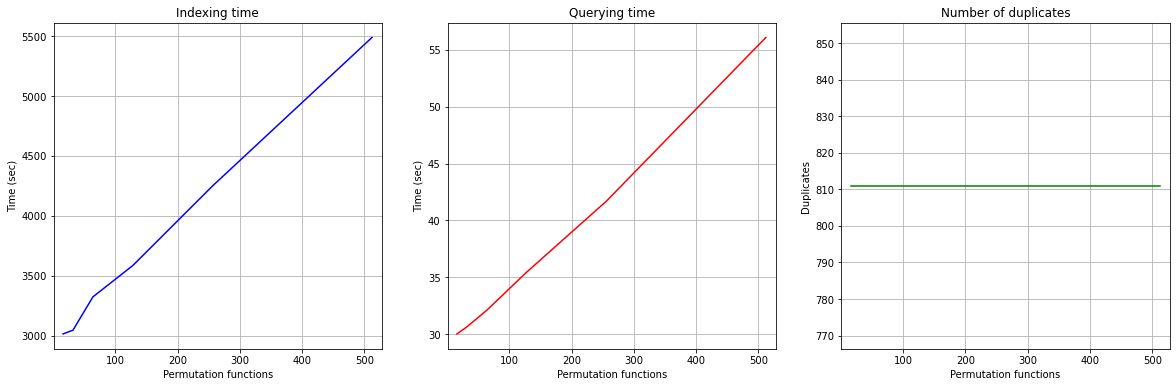

In [22]:
fig = plt.figure(figsize=(20, 6))

plt.subplot(1,3,1)
plt.plot(perm_list, index_times, color='b')
plt.xlim(1,perm_list[-1]+perm_list[0])
plt.grid(True)
plt.xlabel('Permutation functions')
plt.ylabel('Time (sec)')
plt.title("Indexing time")

plt.subplot(1,3,2)
plt.plot(perm_list, query_times, color='r')
plt.xlim(1,perm_list[-1]+perm_list[0])
plt.grid(True)
plt.xlabel('Permutation functions')
plt.ylabel('Time (sec)')
plt.title("Querying time")

plt.subplot(1,3,3)
plt.plot(perm_list, duplicates, color='g')
plt.xlim(1,perm_list[-1]+perm_list[0])
plt.grid(True)
plt.xlabel('Permutation functions')
plt.ylabel('Duplicates')
plt.title("Number of duplicates")

plt.grid(True)
plt.show()

We can see that the indexing time increases significantly with the number of permutation functions, while the querying time slightly increases as the number of permutation functions increases.<br>
Furthermore, the number of duplicates is exactly the same regardless of the number of permutation functions.<br>
Finally, compared to the One-VS-All approach, we notice that the number of duplicates is significantly higher when we use LSH. This happens is because of the false positives that are unavoidable when using LSH.